## Explainability von Machine Learning Modellen: Der Einfluss von Trainings- und Testdaten auf ein Multilayer Perceptron
Dieses Notebook ist Teil von <a href='https://datenverknoten.de/?p=238' target='_blank'>einem Artikel</a> auf www.datenverknoten.de.
<br>Quelle des verwendeten Datensatzes: https://www.kaggle.com/lirilkumaramal/heart-stroke

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

### Datenvorbereitung
Zunächst wird der Datensatz in ein Pandas DataFrame geladen. Es handelt sich hierbei um verschiedene Parameter aus dem Gesundheitsbereich, die zur Vorhersage eines 
Infarktes verwendet werden können. 

In [96]:
stroke_raw = pd.read_csv('rawdata/train_strokes.csv').drop(columns=['id'])

Ein Blick auf die Daten zeigt, dass es sich bei diesem Datensatz um kategorische (gender, ever_married, work_type, Residence_type, smoking_status), diskrete (hypertension, heart_disease, stroke) und stetige Variablen (age,avg_glucose_level,bmi) handelt.

In [97]:
stroke_raw.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Insgesamt sind 43400 Instanzen vorhanden.

In [98]:
len(stroke_raw)

43400

Die kategorischen Daten werden mit einem LabelEncoder in Zahlenwerte überführt. Dies verursacht potenziell Probleme, wie bereits im ersten Teil beschrieben wurde. Es wird hier nicht weiter darauf eingegangen. Durch das Encoding werden Zeilen, in denen sich ein NaN in irgendeiner der zu encodierenden Spalten befindet, ausgelassen.

In [99]:
labelencoder = LabelEncoder()
stroke_pre = stroke_raw.copy()
stroke_pre = stroke_pre.dropna()
stroke_pre['gender'] = labelencoder.fit_transform(stroke_pre['gender'])
stroke_pre['ever_married'] = labelencoder.fit_transform(stroke_pre['ever_married'])
stroke_pre['work_type'] = labelencoder.fit_transform(stroke_pre['work_type'])
stroke_pre['Residence_type'] = labelencoder.fit_transform(stroke_pre['Residence_type'])
stroke_pre['smoking_status'] = labelencoder.fit_transform(stroke_pre['smoking_status'])

Für das Training ist es hilfreich, wenn die Daten skaliert werden, da sonst der Einfluss einer deutlich größeren Variable, wie z.B. Alter, die Wichtigkeit der anderen Variablen negativ beeinflussen kann.

In [100]:
cols = stroke_pre.columns
stroke_pre_unscaled = stroke_pre.values
min_max_scaler = preprocessing.MinMaxScaler()
stroke_pre_scaled = min_max_scaler.fit_transform(stroke_pre_unscaled)
stroke_pre_scaled = pd.DataFrame(stroke_pre_scaled,columns=cols)

Die Daten sind nun skaliert.

In [101]:
stroke_pre_scaled.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.5,0.666667,1.0,0.0,1.0,0.50,1.0,0.139595,0.355311,0.5,0.0
1,0.0,0.833333,0.0,0.0,1.0,0.50,0.0,0.059439,0.315018,0.0,0.0
2,0.0,0.583333,0.0,0.0,1.0,0.50,1.0,0.095662,0.092796,0.0,0.0
3,0.0,0.902778,0.0,1.0,1.0,0.75,0.0,0.798678,0.206349,0.5,0.0
4,0.0,0.305556,0.0,0.0,1.0,0.50,0.0,0.096001,0.271062,1.0,0.0


Beide Klassen (stroke 0,1 = Nein, Ja) sind stark unausgeglichen. Es gibt 28524 Instanzen für stroke = 0 und 548 für stroke = 1.

In [102]:
print(list(stroke_pre_scaled['stroke']).count(0))
print(list(stroke_pre_scaled['stroke']).count(1))

28524
548


Da es unpraktisch wäre, alle möglichen Subsets der Daten mit stroke = 0 mit einer Größe von 548 zu erstellen und für das Training des Multilayer Perceptron zu nutzen, wird stattdessen ein <i>sliding window</i> verwendet. Dies läuft Instanz für Instanz über alle stroke = 0 Daten und pickt jeweils 548 dieser Instanzen heraus, kombiniert sie mit allen stroke = 1 Daten und erstellt somit einen ausgeglichenen Datensatz. Damit dies möglich wird, werden die beiden Klassen aufgeteilt.

In [103]:
stroke_0 = stroke_pre_scaled[stroke_pre_scaled['stroke']==0]
stroke_1 = stroke_pre_scaled[stroke_pre_scaled['stroke']==1]

### Abschätzung der Wichtigkeit der einzelnen Features
Um abschätzen zu können, wie wichtig welches Feature (Variable) für die Vorhersage ist, wird ein Ensemble Algorithmus verwendet. Dieser erstellt 25 Entscheidungsbäume jeweils auf unterschiedlichen Subsets der Daten und bestimmt dabei, wie wichtig ein Feature für die Vorhersage ist. Dies wird für alle Datensätze, die im <i>sliding window</i> entstehen, ausgeführt. Dabei wird pro Ausführung eine Tabelle erhalten, welche die Wichtigkeit der einzelnen Features beinhaltet. Diese Ergebnisse werden in einem Pandas DataFrame (importancyframe) gesammelt.

<b>Plot 0: </b>Zuvor werden aber noch die Rohdaten gegeneinander aufgetragen.

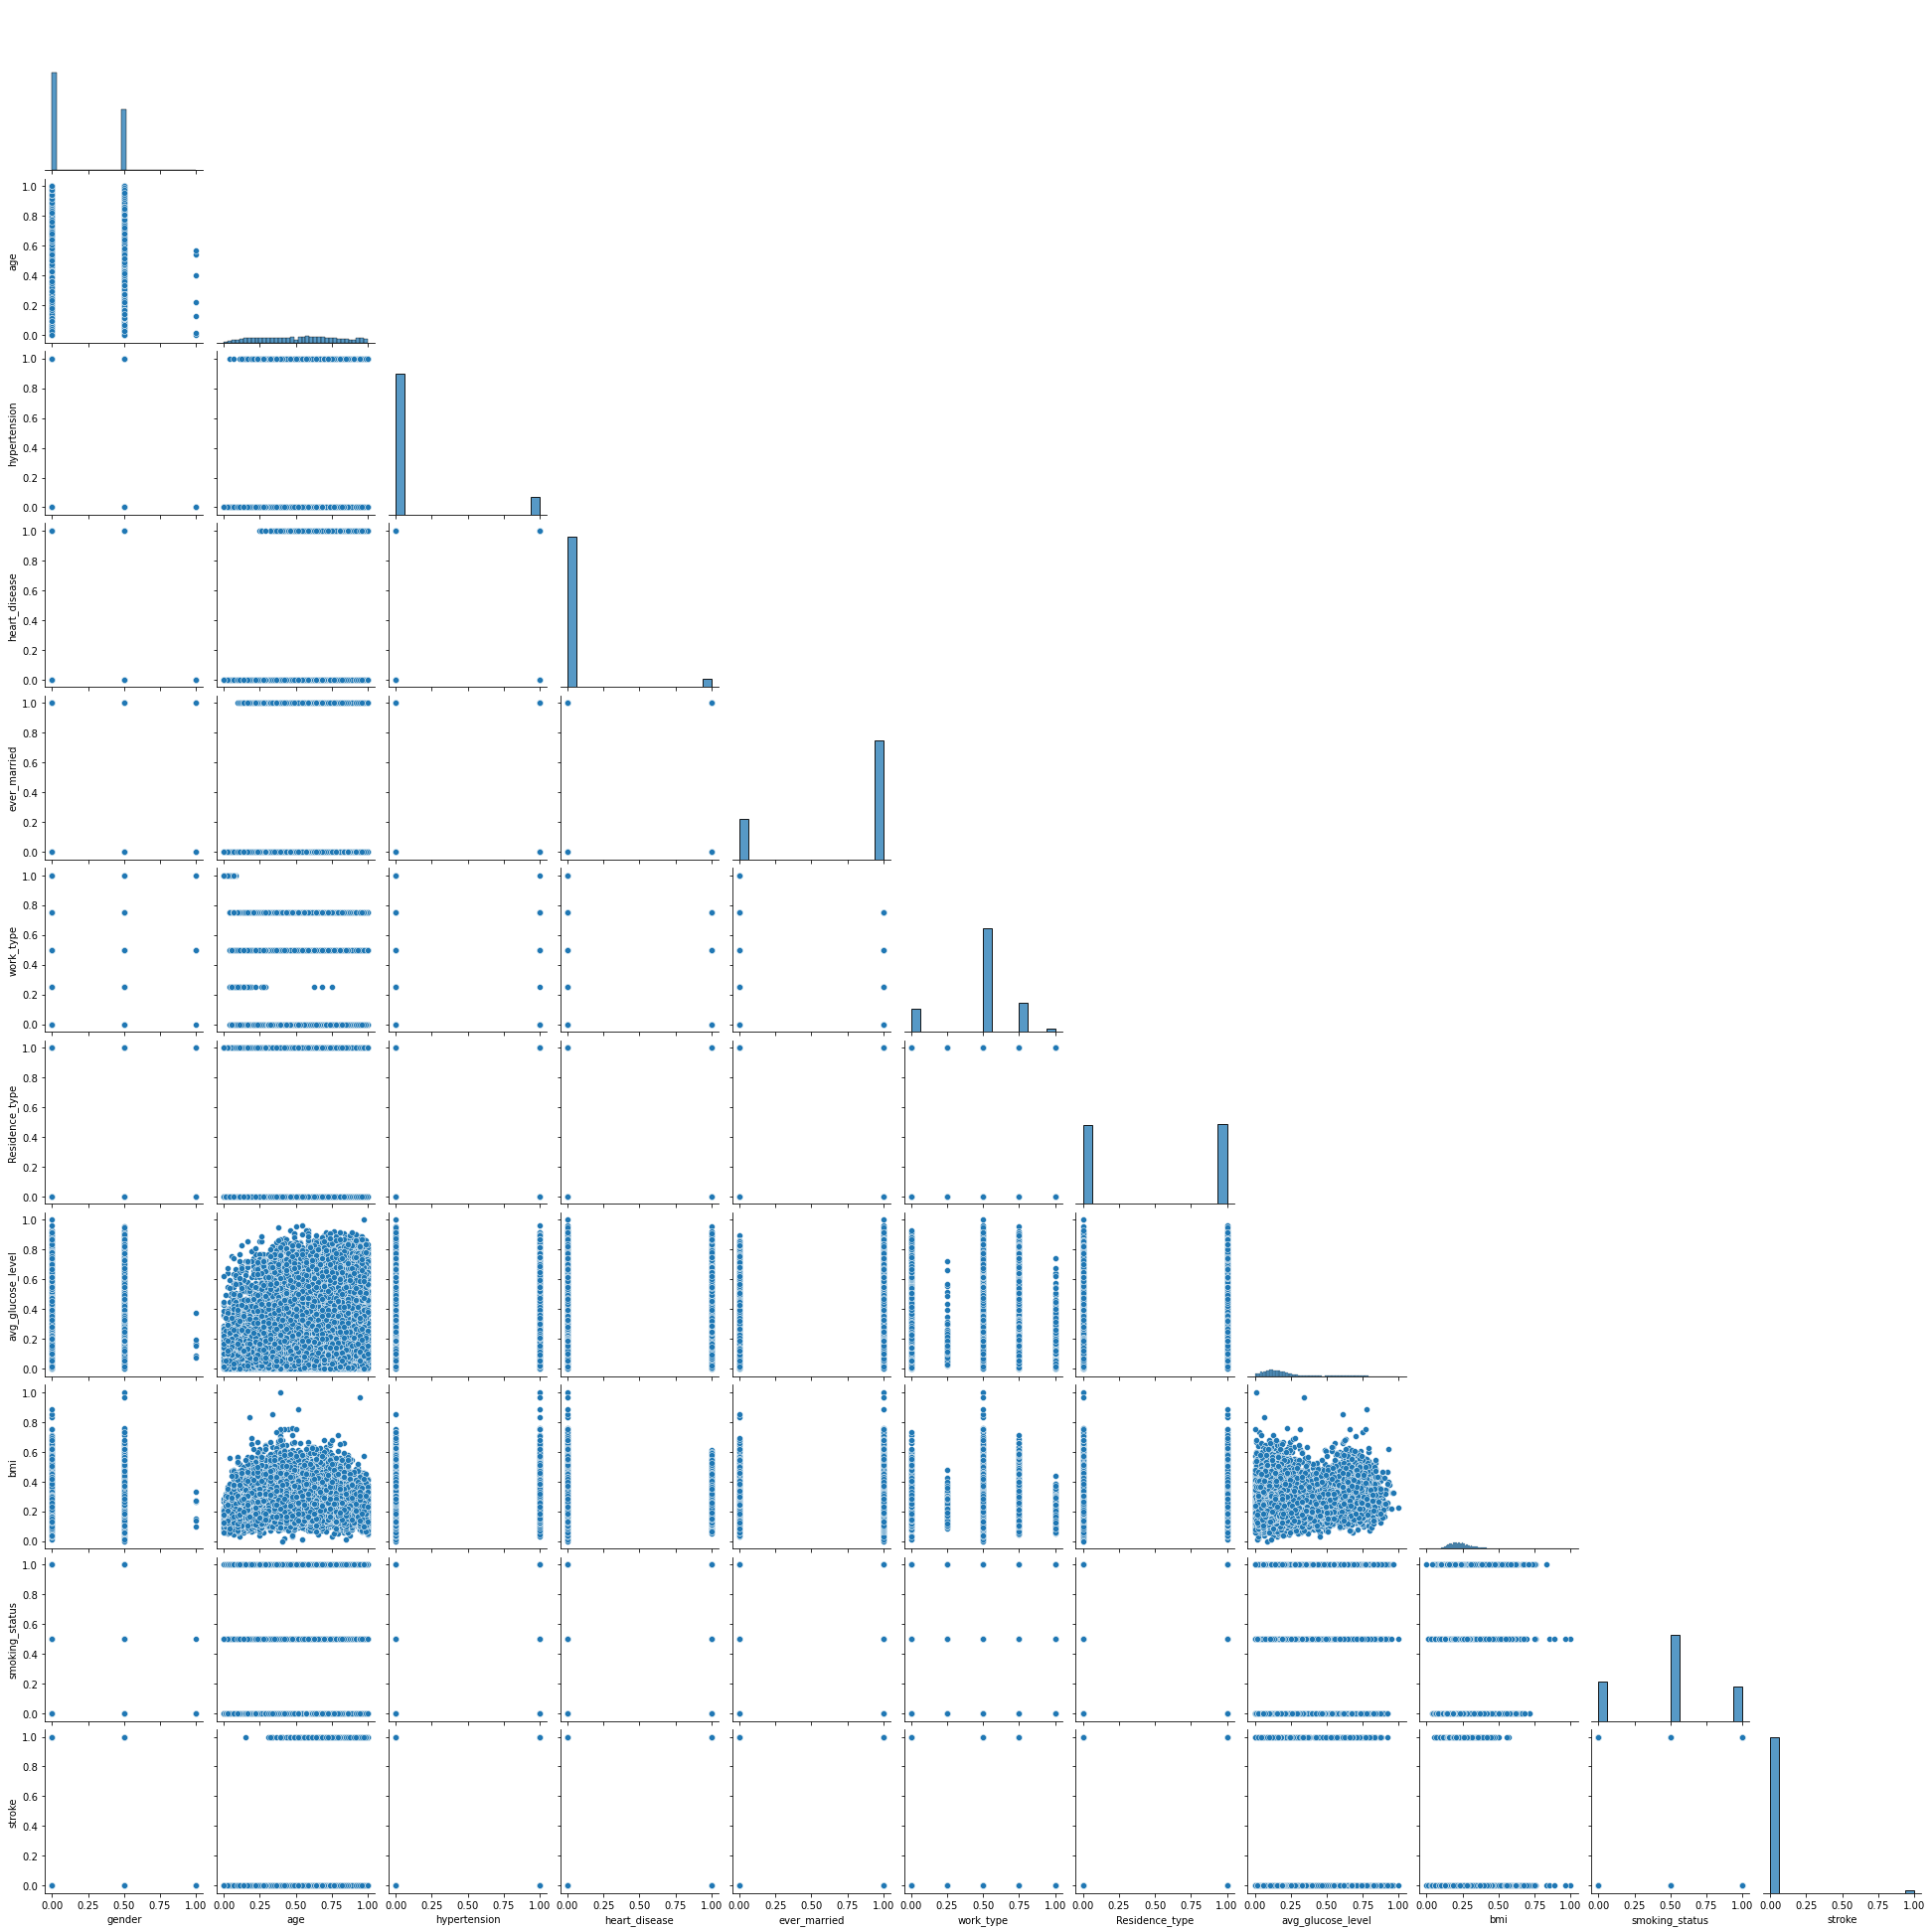

In [110]:
_ = sns.pairplot(stroke_pre_scaled, corner = True)

In [104]:
# Hier wird das Model für die Bestimmung der Feature importance initialisiert
model = ExtraTreesClassifier(n_estimators = 25, random_state = 1)
columnnames = stroke_pre_scaled.drop(columns=['stroke']).columns
importancyframe = pd.DataFrame(columns=columnnames)

# Sliding window
for i in range(548,len(stroke_0)):
    if(i % 1000 == 0):
        print(i)
    # Das sliding window kommt dadurch zu stande, dass inkrementell immer eine Instanz (von 'oben' gesehen)
    # hinzugenommen wird und von dieser Menge dann die untersteten 548 herausgenommen werden.
    stroke_0_set = stroke_0[stroke_0['stroke']==0].head(i).tail(548)
    attached_set = stroke_0_set.append(stroke_1)
    # Erstellung der Einflussgrößen und der Zielgröße
    X = attached_set.drop(columns=['stroke'])
    y = attached_set['stroke']
    
    # Fitting der Entscheidungsbäume
    model.fit(X,y)   
    tmpframe = pd.DataFrame()
    # Erstellung eines DataFrames für die Wichtigkeiten (feature_importances_)
    tmpframe['feature'] = columnnames
    tmpframe['imps'] = model.feature_importances_

    # Transponieren des DataFrames
    tmpframe_transposed = tmpframe.T
    # Die 'Überschriften' der Spalten werden entfernt und die Zeile wird dem DataFrame angefügt.
    tmpframe_transposed.columns = list(tmpframe_transposed.iloc[0])
    tmpframe_transposed = tmpframe_transposed.drop('feature')
    importancyframe = importancyframe.append(tmpframe_transposed)
    
# Alle Spalten werden in den Datentyp float überführt
importancyframe = importancyframe.astype(float)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


Die Wichtigkeit der einzelnen Features (im Mittel) sieht wie folgt aus:

In [112]:
importancyframe.mean()

gender               0.032614
age                  0.359921
hypertension         0.043201
heart_disease        0.044693
ever_married         0.028312
work_type            0.056105
Residence_type       0.034282
avg_glucose_level    0.182089
bmi                  0.161283
smoking_status       0.057500
dtype: float64

<b>Plot1:</b> Die Verteilung der Wichtigkeiten wird geplottet. Dabei wird in jedem Plot eine Normalverteilung mit den Parametern der Verteilung der Wichtigkeit (Mittelwert, Standardabweichung) angezeigt. Dabei ist zu erkennen, dass jede Verteilung der Wichtigkeit anscheinend einer Normalverteilung folgt.

P-Value for gender: 0.23756355485960992
P-Value for age: 0.573770234590661
P-Value for hypertension: 0.9561048765135371
P-Value for heart_disease: 0.7849624028071216
P-Value for ever_married: 0.36554068342412405
P-Value for work_type: 0.09515015709495615
P-Value for Residence_type: 0.04234933292931855
P-Value for avg_glucose_level: 0.31192951962314164
P-Value for bmi: 0.9442040636118352
P-Value for smoking_status: 0.6583323160316996


<Figure size 432x288 with 0 Axes>

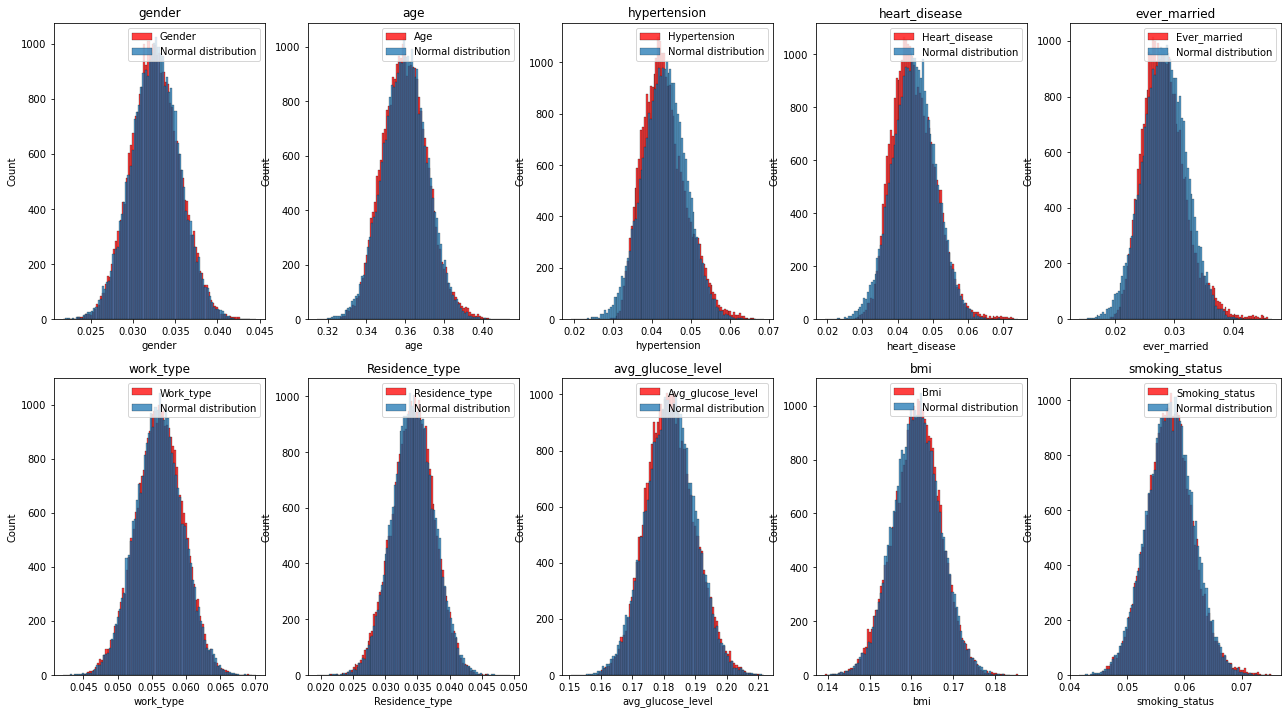

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [115]:
fig, axes = plt.subplots(2, 5, figsize=(22, 12))
row = 0
colc = 0
for i,col in enumerate(importancyframe.columns):
    _ = plt.figure(i)
    # Plot der Wichtigkeitsverteilung
    ax = sns.histplot(importancyframe[col],kde=False,label=col.capitalize(),color='r',ax = axes[row, colc]).set_title(col)
    # Erstellung einer Normalverteilung mit den Werten der Wichtigkeitsverteilung
    x = np.random.normal(size=len(importancyframe[col]),loc=importancyframe[col].mean(),scale=importancyframe[col].std())
    # Plot der Normalverteilung
    ax = sns.histplot(x,kde=False,label='Normal distribution',ax = axes[row, colc]);
    _ = ax.legend()
    
    res = stats.ttest_ind(importancyframe[col], x)
    print('P-Value for '+str(col)+": "+str(res[1]))
    
    # Bestimmung der Spalte und Zeile
    colc += 1
    if(colc == 5):
        colc = 0
        row += 1

<b>Plot 2: </b>Im Pairplot ist zu sehen, dass es wohlmöglich einen mittelstarken negativen linearen Zusammenhang zwischen age und avg_glucose_level gibt. Dies bedeutet, dass bei steigender Wichtigkeit von age, das Feature avg_glucose_level an Wichtigkeit verliert. Dies ist auch für age und bmi zu erkennen.

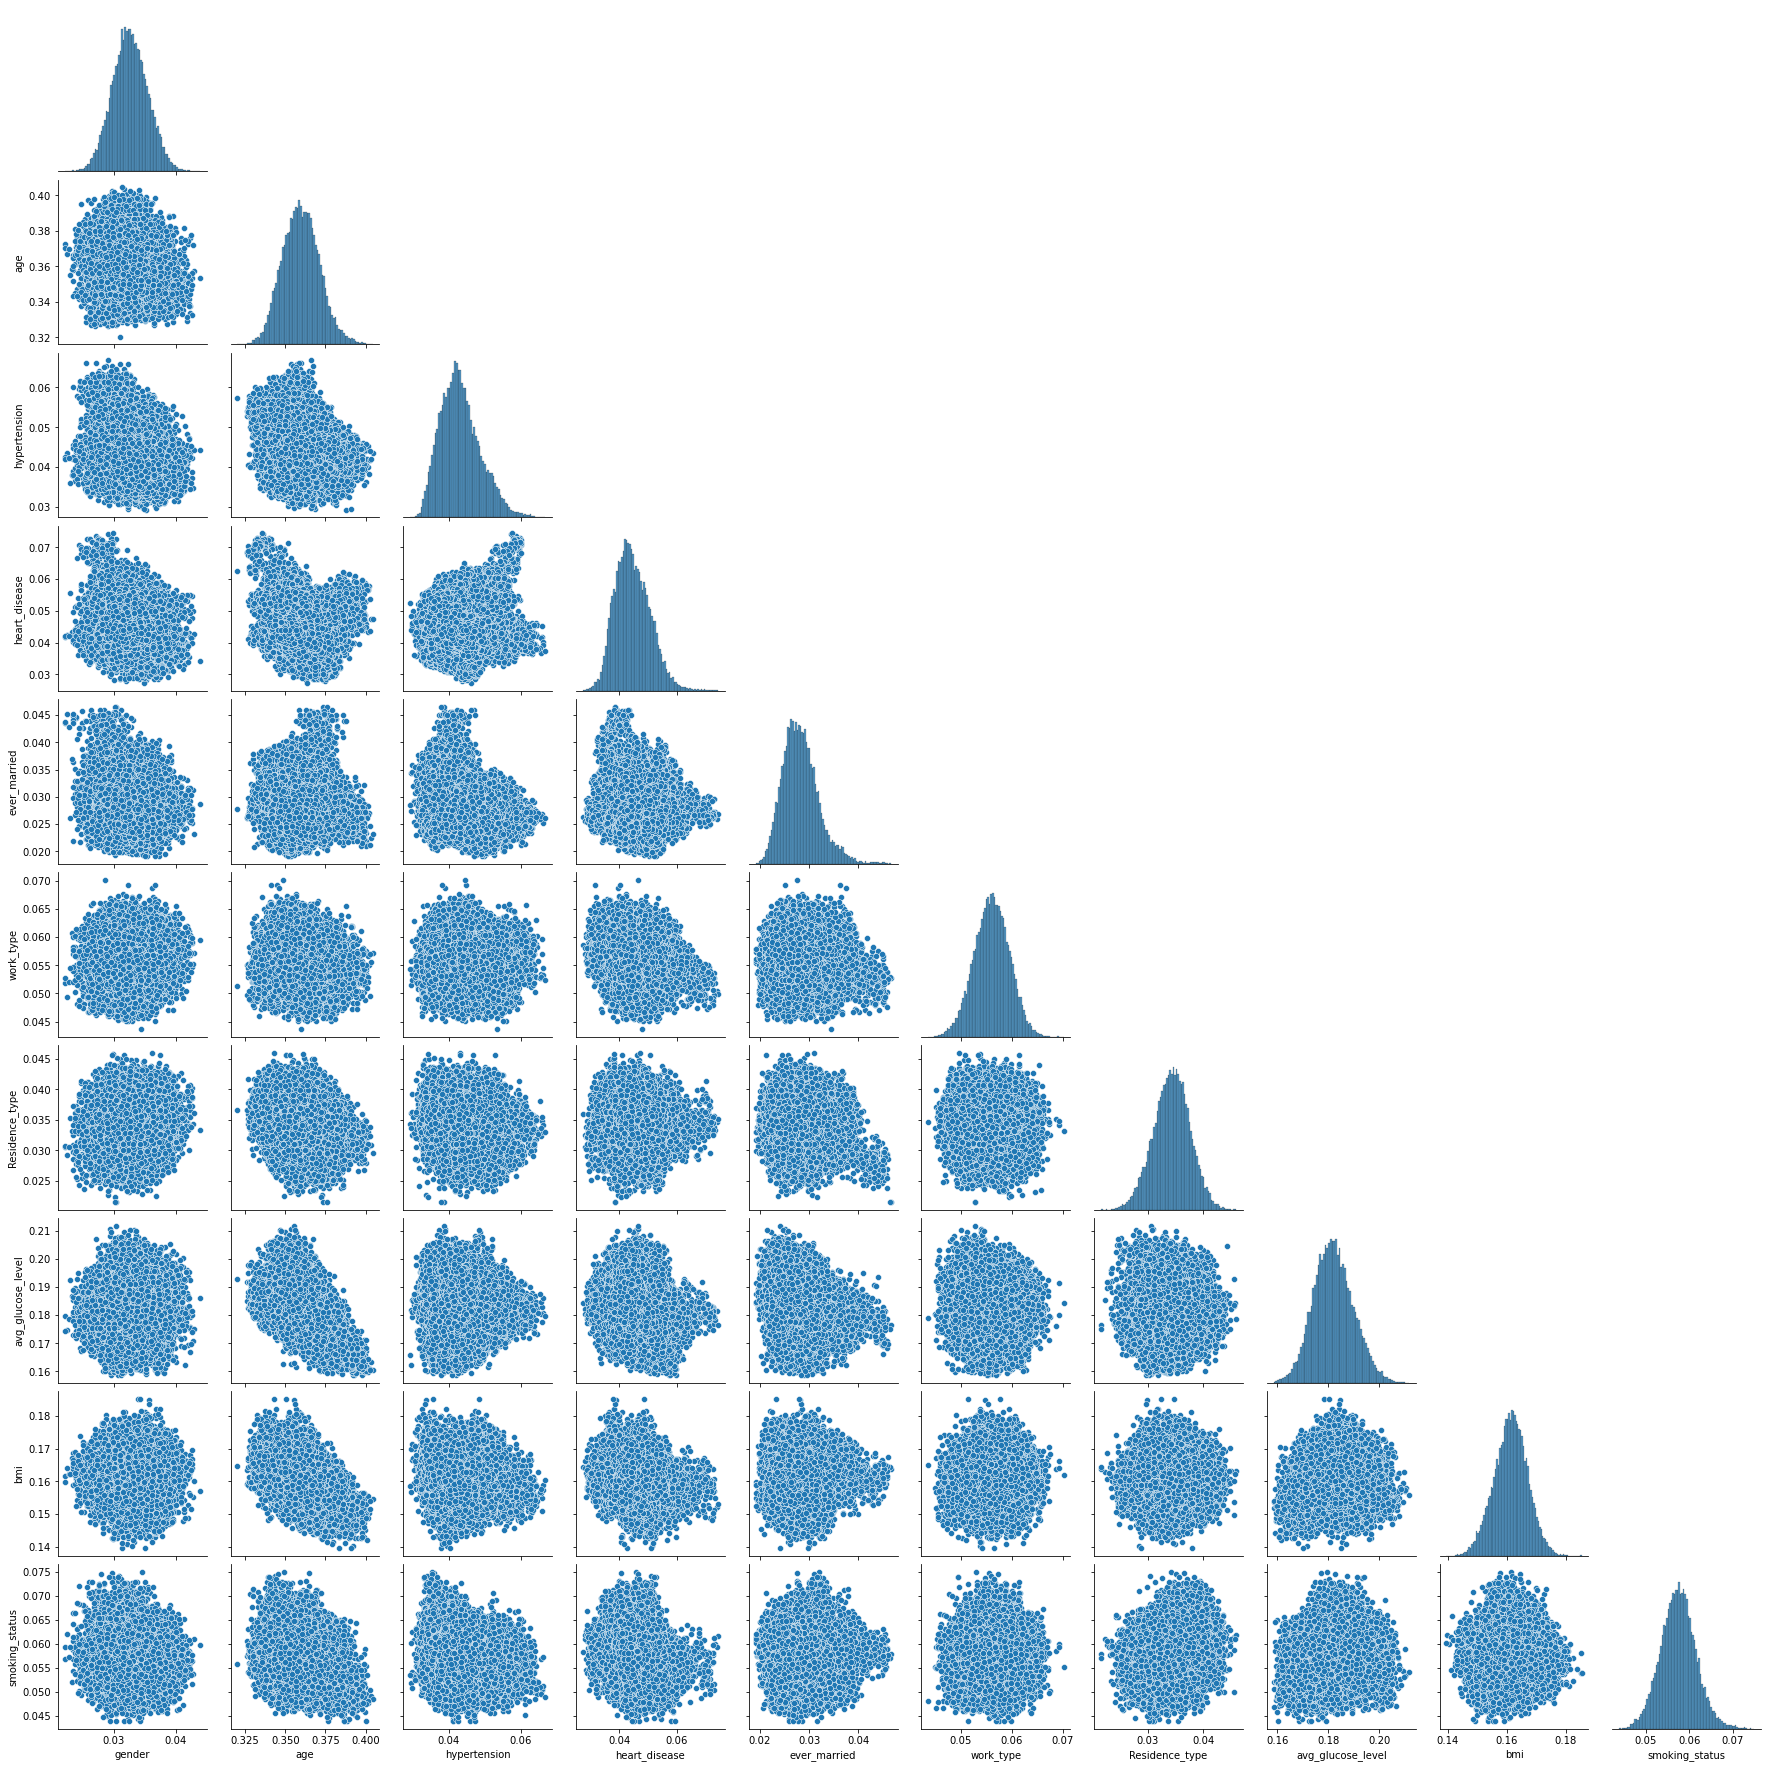

In [116]:
_ = sns.pairplot(importancyframe, corner = True)

<b>Plot 3: </b>Der Verdacht, dass age mit avg_glucose_level und age mit bmi eine mittelstarke negative Korrelation verbindet, lässt sich im Korrelationskoeffizienten in der Heatmap erkennen. Interessanterweise sind diese beiden Features aber nebensächlich, wie sich zeigen wird.

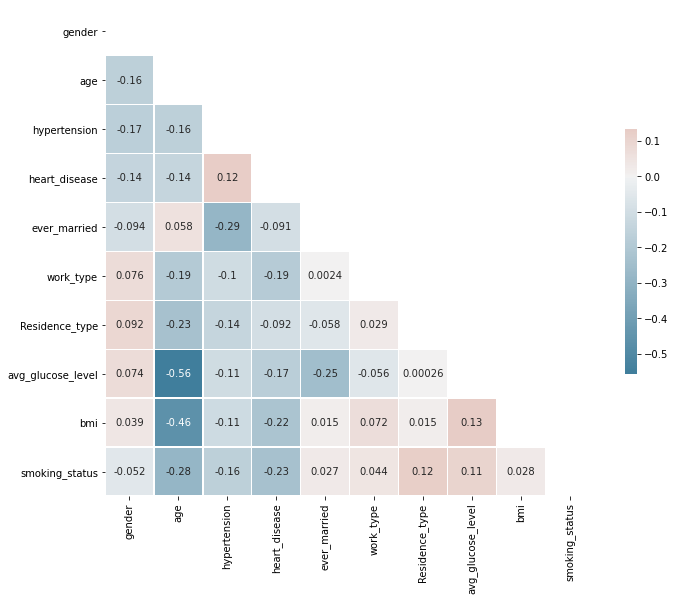

In [119]:
# Berechnen des Korrelationskoeffizienten.
corr = importancyframe.corr()
# Erstellen einer Maske für die obere Hälfte der Matrix, da es in der Heatmap kein corner-Parameter gibt.
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Eine Colormap wird erstellt
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Die Heatmap wird mit der Maske und der Colormap erstellt. Die Korrelationskoeffizienten werden in der Matrix eingetragen.
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Multilayer Perceptron Training und Testing
Um einen Eindruck darüber zugewinnen, wie die Zusammensetzung des Trainings- und Testdatensatzes die Geanuigkeit des MLP bestimmt, werden die jeweiligen Mittelwerte der Features zusammen mit der Genauigkeit in einem DataFrame gesammelt. Anschließend werden für alle Paare (z.B. age-train, age-test) t-Tests mit einem p-value von 0.05 zur Annahme der Nullhypothese (es gibt keinen Unterschied zwischen beiden Verteilungen) durchgeführt. Sollte es zu einer Ablehnung der Nullhypothese in einzelnen Fällen kommen, bedeutet dies, dass das MLP auf einem Datensatz trainiert wurde, der sich in einem oder mehreren Features vom Testdatensatz unterscheidet. Dies kann zu einer schlechteren Genauigkeit führen, da das Modell für eine Situation aus dem Testdatensatz ggf. nicht vorbereitet ist und durch eine fehlerhafte Abstraktion der Daten eine falsche Vorhersage trifft.

In [10]:
# Dieser DataFrame wird die Ergebnisse sammeln
resultframe = pd.DataFrame()

# Sliding window wie zuvor auch
for i in range(548,len(stroke_0)):
    if(i % 1000 == 0):
        print(i)
    # Zusammensetzen des Datensatzes
    stroke_0_set = stroke_0[stroke_0['stroke']==0].head(i).tail(548)
    attached_set = stroke_0_set.append(stroke_1)
    X = attached_set.drop(columns=['stroke'])
    y = attached_set['stroke']
    # Es wird ein Train-Test Split erstellt
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=2)

    # Die berechnete Accuracy soll auf die Eigenschaften des Trainings- und Testdatensatzes bezogen werden. 
    # Darum werden die Mittelwerte der einzelnen Features bestimmt.
    stats_1 = X_train.mean().to_dict()
    stats_2 = X_test.mean().to_dict()
    # Das MLP wird trainiert
    clf_mlp = MLPClassifier(random_state=1, max_iter=1500,hidden_layer_sizes=(5, 2))
    clf_mlp.fit(X_train, y_train)
    
    # Die Mittelwerte der Features aus Trainings- und Testdatensatz werden in ein dictionary überführt.
    tmpdict = {}
    for key in stats_1.keys():
        tmpdict[str(key)+'_train'] = stats_1[key]
    stats_1 = tmpdict
    
    tmpdict = {}
    for key in stats_2.keys():
        tmpdict[str(key)+'_test'] = stats_2[key]
    stats_2 = tmpdict
    
    stats_comp = stats_1
    stats_comp.update(stats_2)
    stats_comp['accuracy'] = clf_mlp.score(X_test,y_test)

    # Das dictionary wird dem DataFrame hinzugefügt
    resultframe = resultframe.append(stats_comp,ignore_index = True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


<b>Plot 4: </b>In den Verteilungen der Mittelwerte der einzelnen Features lässt sich erkennen, dass diese sich teilweise unterscheiden. Allerdings ist hier der absolute Wert zu beachten, die Unterschiede sind nicht allzu stark. Es fällt aber auf, dass die beiden unterschiedlichen Verteilungen pro Feature besonders deutlich beim Feature hypertension. In den Trainingsdaten finden sich also tendenziell mehr Instanzen, die eine hypertension = 1 haben.

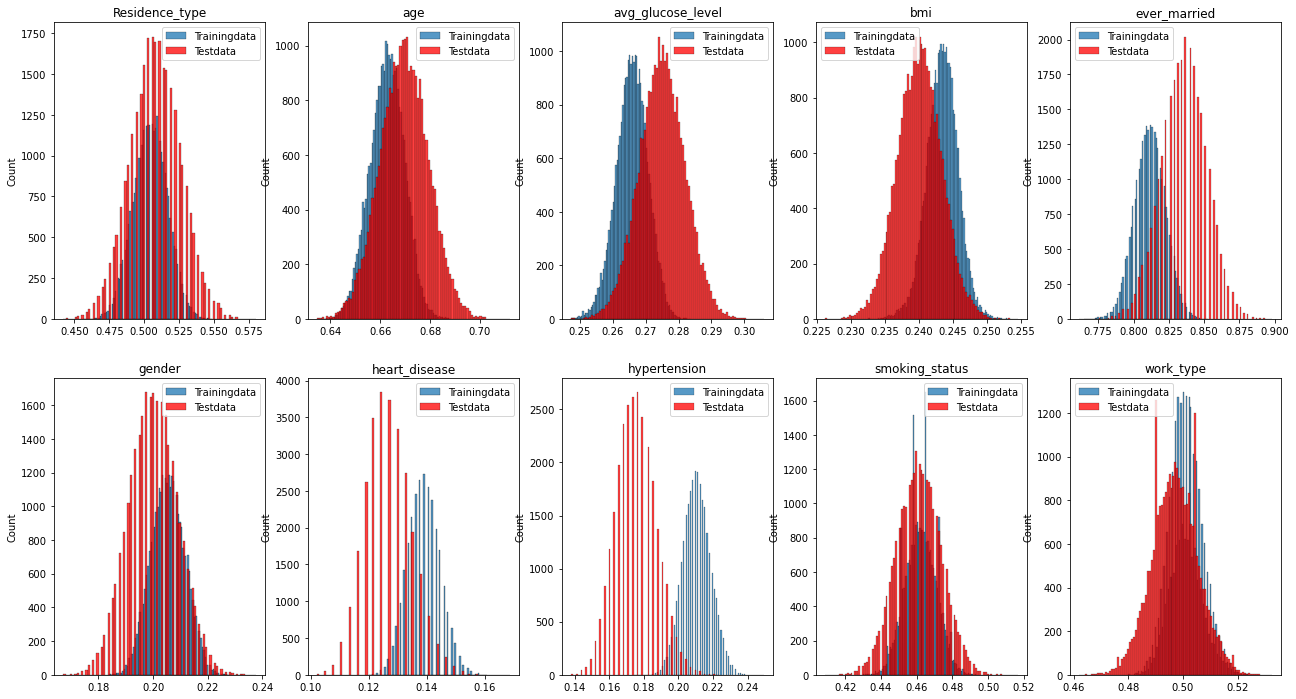

<Figure size 432x288 with 0 Axes>

In [120]:
fig, axes = plt.subplots(2, 5, figsize=(22, 12))
row = 0
colc = 0

# Verteilungen über die Features werden geplottet. Jeweils die Trainings- zu den Testdaten.
train_columns = [col for col in resultframe.columns if 'train' in col]
for col in train_columns:
    _ = plt.figure(i)
    ax = sns.histplot(resultframe[col], ax = axes[row, colc], label = 'Trainingdata').set_title(col.replace('_train',''))
    ax = sns.histplot(resultframe[col.replace('train','test')], ax = axes[row, colc], label = 'Testdata', color = 'r')
    _ = ax.legend()
    ax.set_xlabel('')
    # Bestimmung der Spalte und Zeile
    colc += 1
    if(colc == 5):
        colc = 0
        row += 1

<b>Plot 5: </b>In einer Heatmap zur Korrelation der einzelnen Features, insbesondere mit der Accuarcy, lässt sich sehen, dass age_test mittelstark negativ mit der Genauigkeit korreliert. Das bedeutet also, mit sinkendem Alter der Instanzen im Mittel, steigt die Genaugikeit. Interessanterweise ist dies bei den Trainingsdaten (age_train) nicht der Fall. Hier ist keine Korrelation zu erkennen. Die Verteilungen zuvor (Plot 4) zeigen, dass das Alter nahezu gleichmäßig in den Trainings- und Testdaten verteilt ist, auch wenn die Testdaten einen etwas größeren Altersbereich in höhere Alter abdecken. Es ist also unwahrscheinlich, dass ein Bias in den Daten für die Genauigkeitsschwankungen hinsichtlich dieses Features verantwortlich ist. 

Zudem ist eine schwache negative Korrelation der Genauigkeit mit heart_disease und hypertension, jeweils in den Testdaten, zu erkennen. Da in den Verteilungen zuvor zu sehen war, dass das Features hypertension in den Trainingsdaten häufiger den Wert 1 hat als in den Testdaten, lässt sich darauf schließen, dass das MLP bessere Vorhersagen treffen kann, wenn weniger Instanzen mit hypertension = 1 vorhanden sind. Dies scheint also ein störendes Feature zu sein. Die Verteilungen des Features heart_disease weichen nur schwach voneinander ab. 

Zusammenfassend lässt sich also erkennen, dass es eine Korrelation zwischen Genauigkeit und Alter gibt und diese nicht durch einen Bias zwischen Trainings- und Testdaten entstehen kann. Die Genauigkeit muss also von mindestens einer anderen Variable beeinflusst werden. Das Alter kann somit nicht als alleinige Variable zur Vorhersage genutzt werden.

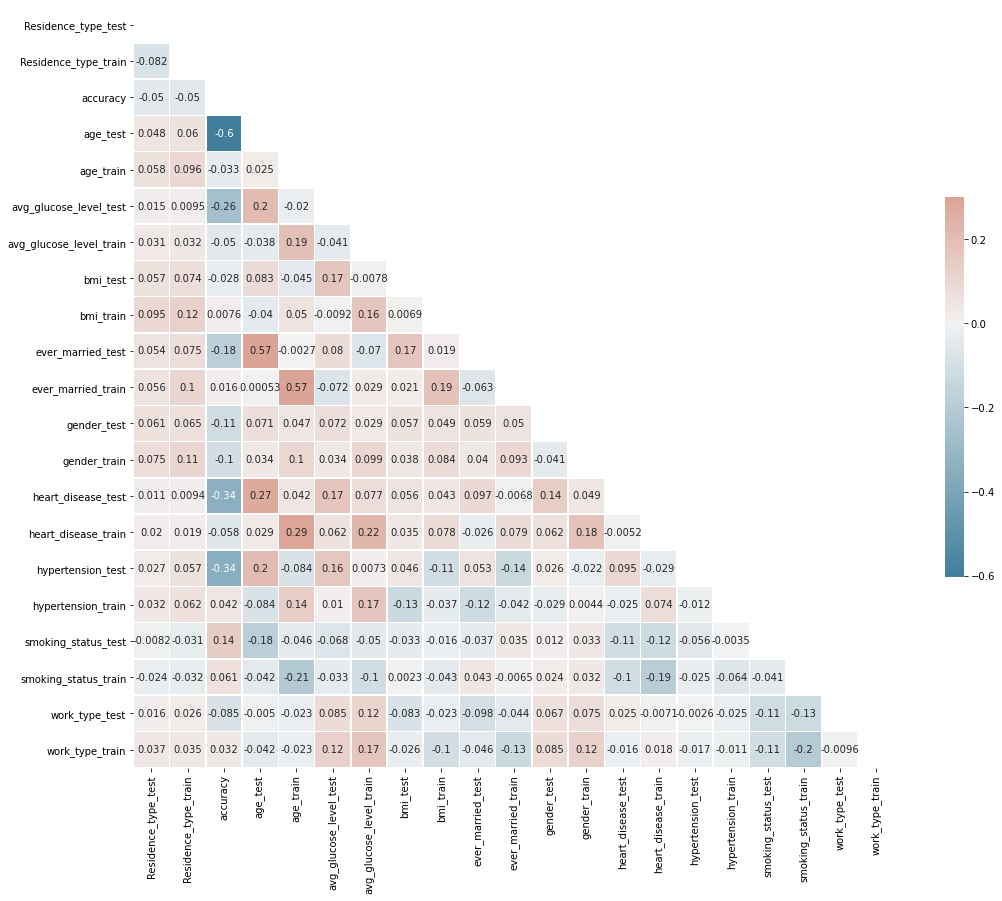

In [122]:
corr = resultframe.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

<b>Plot 6: </b>Als nächstes wird die Verteilung der Genauigkeit des MLP untersucht. Jeder Testlauf im sliding window ergibt eine Genaugikeit mit spezifischen Mittelwerten der einzelnen Features im Trainings- und Testdatensatz. Um die Verteilung mit einer Normalverteilung zu vergleichen, wird eine solche zusätzlich geplottet. Zu erkennen ist, dass die Normalverteilung mit den gleichen Parametern (Mittelwert, Standardabweichung) einen weniger stark ausgeprägten Peak hat. Zudem scheint im mittleren Bereich der Genauigkeit ein Mangel vorzuliegen. Auch gibt es einen kleinen Teil, der unterhalb von 65% Genaugikeit liegt. 

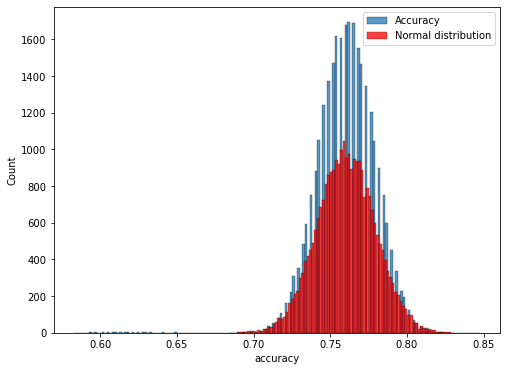

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plot_data = resultframe['accuracy']
ax = sns.histplot(plot_data,kde=False,label='Accuracy')
x = np.random.normal(size=len(plot_data),loc=plot_data.mean(),scale=plot_data.std())
ax = sns.histplot(x,kde=False,label='Normal distribution', color = 'r');
_ = ax.legend()

Um den Bereich unterhalb von 65% Genaugikeit zu untersuchen, wird dieser Prozentsatz als Grenze festgelegt.

In [32]:
# das unterste nehmen.
lowerborder = 0.65

<b>Plot 7: </b>Die folgende Heatmap zeigt die Korrelationen der Features oberhalb der 65% Grenze für die Genauigkeit. Es ist wieder die mittelstarke negative Korrelation der Genauigkeit und des Alters in den Testdaten zu erkennen. Auch die leichten negativen Korrelationen der Genauigkeit zu heart_disease und hypertension lassen sich erkennen, wie schon zuvor in der Heatmap (Plot 5) auch.  

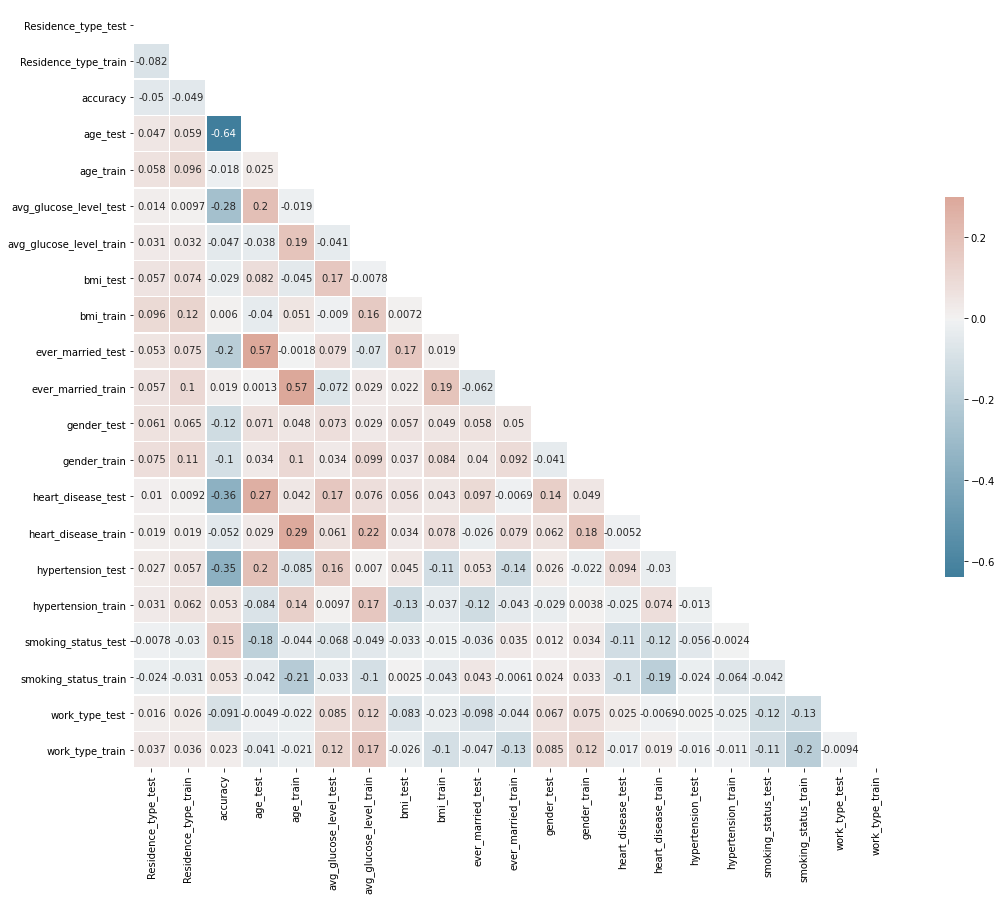

In [132]:
# Es werden nur Läufe verwendet, deren Genauigkeit oberhalb von 65% liegen.
corr = resultframe[resultframe['accuracy']>lowerborder].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 14))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

<b>Plot 8: </b>Anders sieht es bei dem Bereich unterhalb oder gleich 65% Genauigkeit aus. Hier sind insgesamt 55 Ergebnisse vorhanden. Das Alter in den Testdaten korreliert ähnlich stark zur Genauigkeit wie zuvor auch. Deutlich stärker ist aber die Korrelation zu hypertension in den Testdaten. Je häufiger die Instanzen in den Testläufen also hypertension = 0 haben, desto größer wird die Genauigkeit des MLP. Dies gilt ebenso für heart_disease, dass in den Trainingsdaten im Bereich unter 65% Genauigkeit eine stärkere negative Korrelation aufweist als oberhalb dieser Grenze. Dies lässt also die Vermutung zu, dass hypertension und heart_disease störende Variablen für diesen Genauigkeitsbereich sind. 

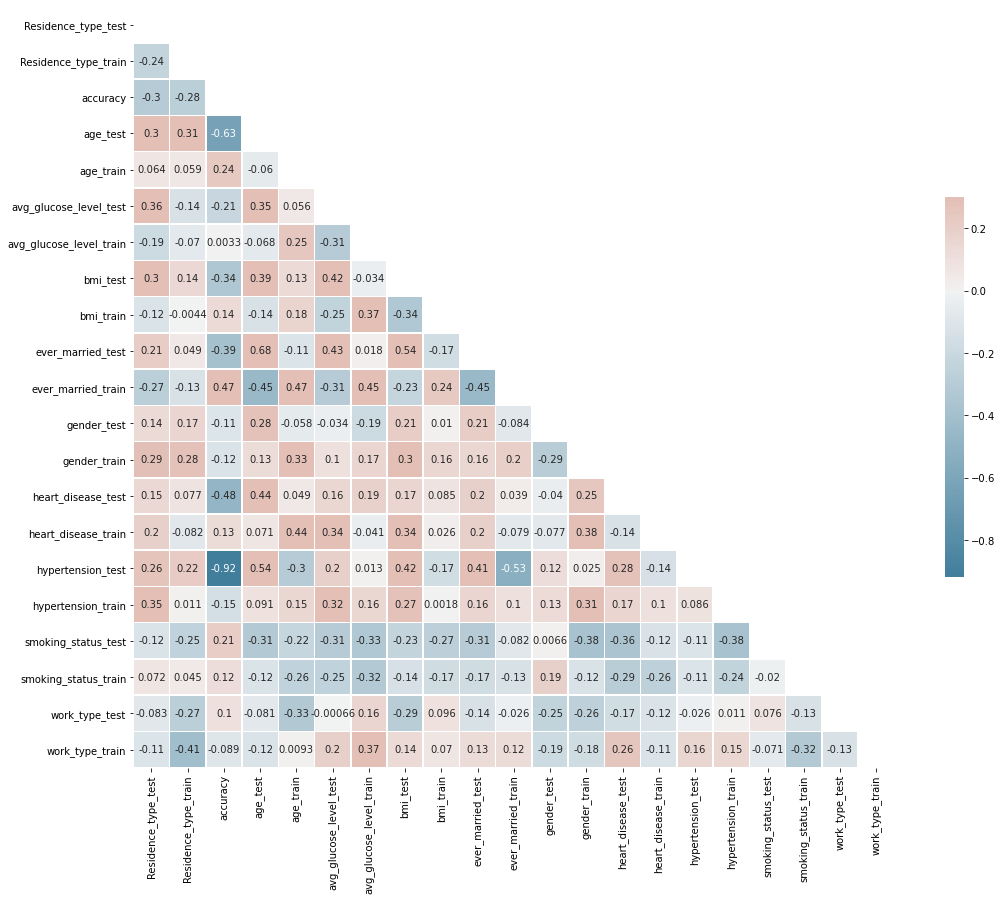

In [133]:
corr = resultframe[resultframe['accuracy']<=lowerborder].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 14))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

<b>Plot 9: </b>Ein Blick auf die Verteilungen der Mittelwerte der Features aus den einzelnen Läufen zeigt, dass diese sich in Trainings- und Testdatensatz unterscheiden. Wird ein T-Test durchgeführt und ein Signifikanzniveau von 5% angenommen, so muss die Nullhypothese (Beide Verteilungen sind gleich, es gibt keinen Unterschied) für hypertension und heart_disease neben einigen anderen Variablen, die keine Korrelation zur Genauigkeit aufweisen, abgelehnt werden.

P-Value for Residence_type: 0.17218390082457544
P-Value for age: 0.9015670770867523
P-Value for avg_glucose_level: 2.7682712048163133e-09
P-Value for bmi: 1.0479380976832927e-10
P-Value for ever_married: 4.446837506354548e-09
P-Value for gender: 4.185548557188945e-09
P-Value for heart_disease: 4.472396935178536e-24
P-Value for hypertension: 6.778252830378362e-34
P-Value for smoking_status: 0.7648769853223298
P-Value for work_type: 0.8353358403496621


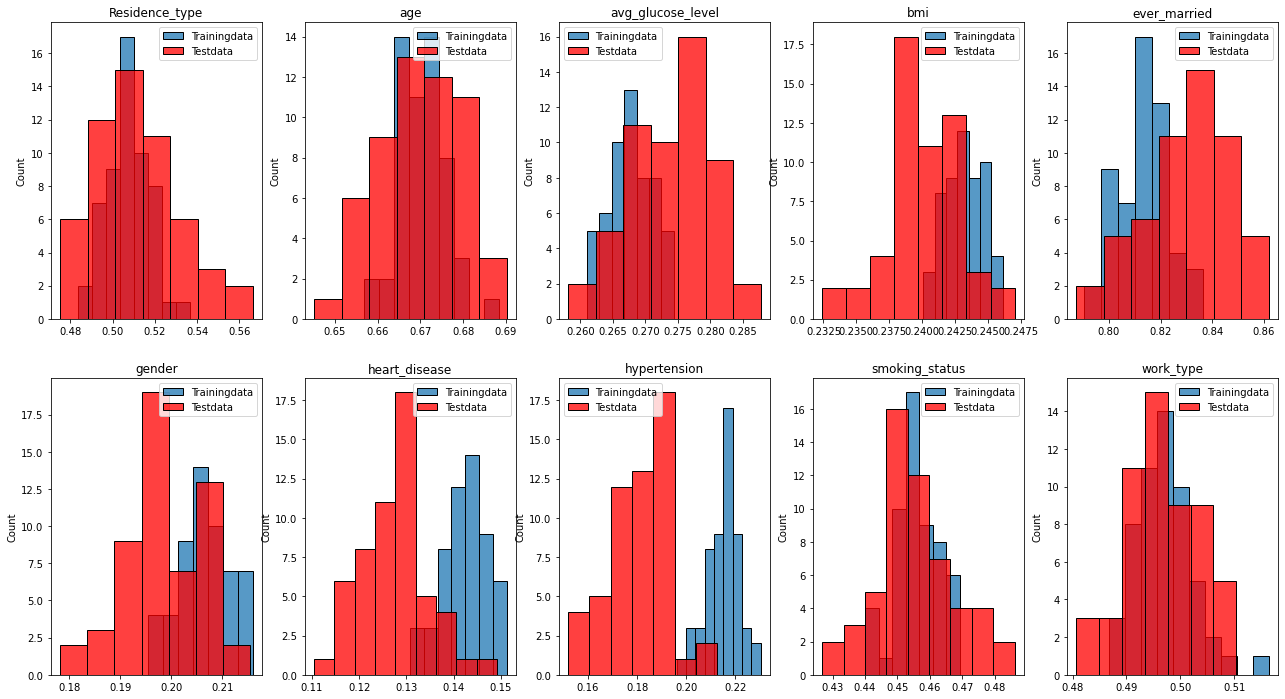

<Figure size 432x288 with 0 Axes>

In [134]:
fig, axes = plt.subplots(2, 5, figsize=(22, 12))
row = 0
colc = 0

# Verteilungen über die Features werden geplottet. Jeweils die Trainings- zu den Testdaten.
train_columns = [col for col in resultframe.columns if 'train' in col]
for col in train_columns:
    _ = plt.figure(i)
    ax = sns.histplot(resultframe[resultframe['accuracy']<=lowerborder][col],\
                      ax = axes[row, colc], label = 'Trainingdata').set_title(col.replace('_train',''))
    ax = sns.histplot(resultframe[resultframe['accuracy']<=lowerborder][col.replace('train','test')], \
                      ax = axes[row, colc], label = 'Testdata', color = 'r')
    _ = ax.legend()
    ax.set_xlabel('')
    # T-Test durchführen
    res = stats.ttest_ind(resultframe[resultframe['accuracy']<=lowerborder][col], \
                          resultframe[resultframe['accuracy']<=lowerborder][col.replace('train','test')])
    
    print('P-Value for '+str(col.replace('_train',': '))+str(res[1]))

    # Bestimmung der Spalte und Zeile
    colc += 1
    if(colc == 5):
        colc = 0
        row += 1#

Dies gilt allerdings auch für den Bereich oberhalb der 65%.

In [62]:
train_columns = [col for col in resultframe.columns if 'train' in col]
for col in train_columns:
    res = stats.ttest_ind(resultframe[resultframe['accuracy']>lowerborder][col], \
                          resultframe[resultframe['accuracy']>lowerborder][col.replace('train','test')])
    
    print('P-Value for '+str(col.replace('_train',': '))+str(res[1]))

P-Value for Residence_type: 6.7135065409294455e-155
P-Value for age: 0.0
P-Value for avg_glucose_level: 0.0
P-Value for bmi: 0.0
P-Value for ever_married: 0.0
P-Value for gender: 0.0
P-Value for heart_disease: 0.0
P-Value for hypertension: 0.0
P-Value for smoking_status: 4.5326220168485737e-35
P-Value for work_type: 0.0


<b>Plot 10: </b>Die Korrelation wird für die drei behandelten Variablen zusammen mit der Genauigkeit geplottet. Dieser Plot zeigt die Ergebnisse unterhalb der 65% Grenze. Die negativen Korrelationen sind deutlich zu erkennen. die Korrelationskoeffizienten entstehen also nicht durch eine Verzerrung der Daten (z.B. gekipptes V).

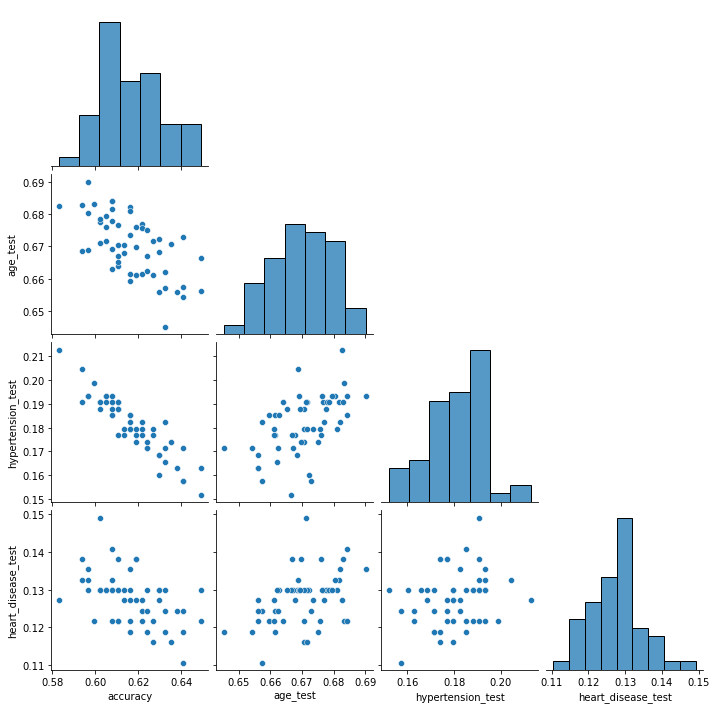

In [135]:
_ = sns.pairplot(resultframe[resultframe['accuracy'] <= lowerborder] \
             [['accuracy','age_test','hypertension_test','heart_disease_test']],corner = True)

<b>Plot 11: </b>Dieser Plot zeigt das in Plot 10 beschriebene für den Bereich oberhalb 65%.

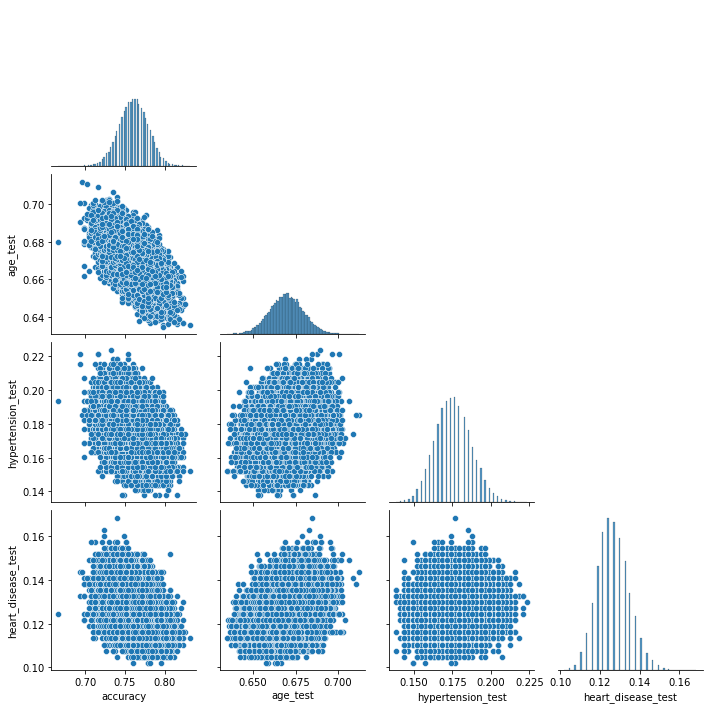

In [136]:
_ = sns.pairplot(resultframe[resultframe['accuracy'] > lowerborder] \
             [['accuracy','age_test','hypertension_test','heart_disease_test']],corner = True)

### Zusammentragen der Fakten
Es besteht also folgende Faktenlage:
<ol>
    <li>hypertension korreliert in den Testdatensätzen wesentlich stärker negativ mit der Genauigkeit im Genauigkeitsbereich des MLP unterhalb von 65% als oberhalb dieser Grenze.</li>
    <li>heart_disease korreliert in den Testdatensätzen etwas stärker negativ mit der Genauigkeit im Genauigkeitsbereich des MLP unterhalb von 65% als oberhalb dieser Grenze.</li>
    <li>Die Verteilung von hypertension zwischen Trainings- und Testdatensätzen ist in beiden Genauigkeitsbereichen statistisch gesehen (P-Wert: 0.05) unterschiedlich.</li>
    <li>Die Verteilung von heart_disease zwischen Trainings- und Testdatensätzen ist in beiden Genauigkeitsbereichen statistisch gesehen (P-Wert: 0.05) unterschiedlich.</li>
    <li>Es besteht eine mittelstarke positive Korrelation zwischen age und hypertension (Testdaten) im Genauigkeitsbereich unter 65%. Diese ist nicht oberhalb der 65% Genauigkeit zu erkennen. (Vgl. Plot 7 - Plot 8)</li>
     <li>Es besteht eine schwache positive Korrelation zwischen age und heart_disease (Testdaten) im Genauigkeitsbereich unter 65%. Diese ist nicht oberhalb der 65% Genauigkeit zu erkennen. (Vgl. Plot 7 - Plot 8)</li>
</ol>

Vereinfacht ausgedrückt lässt sich für den <65% Bereich sagen: 
    <ul>
    <li>Je älter, desto eher Bluthochdruck vorhanden (hypertension)</li>
    <li>Je älter, desto eher Herzerkrankung vorhanden (heart_disease)</li>
    <li>Je älter, desto ungenauer das Modell (gilt für beide Bereiche)</li>
    <li>Je eher Bluthochdruck, desto ungenauer das Modell</li>
    <li>Je eher keine Herzerkrankung, desto ungenauer das Modell</li>
    </ul>
Diese Zusammenhänge lassen vermuten, dass sie die Genauigkeit des Modells beeinträchtigen. Da sie störende Variablen sind, heißt das im Umkehrschluss, dass das Modell sie als wichtig für eine Vorhersage betrachtet. Die anderen Variablen im Datensatz scheinen zweitrangig zu sein. Dies ist insofern seltsam als dass ganz zu Begin bei der Bestimmung der Wichtigkeit herauskam, dass neben age die features bmi und avg_glucose_level am wichtigsten zu sein schienen. Dem lässt sich entgegenstellen, dass dafür natürlich ein anderes Modell genutzt wurde als ein MLP. Hiermit wird deutlich, dass unterschiedliche Modelle also auch unterschiedliche Wichtigkeiten der Features haben können. 